In [13]:
import numpy as np
import gymnasium as gym
from tqdm import tqdm
import matplotlib.pyplot as plt

In [14]:
env = gym.make('Taxi-v3')

In [15]:
def play_policy(env, policy):
    state_action_rewards = []
    state, _ = env.reset()
    done = False
    while not done:
        action = np.random.choice(env.action_space.n, p=policy[state])
        new_state, reward, terminated, truncated, _ = env.step(action)
        state_action_rewards.append((state, action, reward))
        state = new_state
        done = terminated or truncated

    return state_action_rewards

In [35]:
from collections import deque
class SARSAAgent:
    def __init__(self, env):
        self.gamma = 0.9
        self.learning_rate = 0.2
        self.epsilon = 0.01
        self.state_n = env.observation_space.n
        self.action_n = env.action_space.n
        self.q = np.zeros((self.state_n, self.action_n))

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == "train":
            self.trajectory = deque(maxlen=8)

    def step(self, observation, reward, terminated):
        """
        Choose an action according to the current policy.
        Call this during an episode.
        :param observation:
        :param reward:
        :param terminated:
        :return:
        """
        if self.mode == "train" and np.random.uniform() < self.epsilon:
            action = np.random.randint(self.action_n)
        else:
            action = self.q[observation].argmax()

        if self.mode == "train":
            self.trajectory.extend([observation, reward, terminated, action])
            if len(self.trajectory) >= 8:
                self.learn()
        return action

    def close(self):
        pass

    def learn(self):
        state, _, _, action, next_state, reward, terminated, next_action = list(self.trajectory)
        target = reward + self.gamma * self.q[next_state, next_action] * (1 - terminated)
        td_error = target - self.q[state, action]
        self.q[state, action] += self.learning_rate * td_error

In [38]:
def play_episode(env, agent, seed=None, mode=None):
    observation, _ = env.reset(seed=seed)
    reward, terminated, truncated = 0., False, False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0

    done = False
    while not done:
        action = agent.step(observation, reward, terminated)
        observation, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        done = terminated or truncated

    agent.close()
    return episode_reward, elapsed_steps

agent = SARSAAgent(env)

episode_rewards = []
progress = tqdm(range(500000))
for episode in progress:
    episode_reward, elapsed_steps = play_episode(env, agent, seed=episode, mode='train')
    episode_rewards.append(episode_reward)

    mean_reward = np.mean(episode_rewards[-200:])
    progress.set_postfix({'mean_reward': mean_reward})
    if mean_reward > env.spec.reward_threshold - 0.5:
        print("breaking")
        break

  1%|          | 2863/500000 [00:02<05:33, 1489.74it/s, mean_reward=4.84]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

  1%|          | 5853/500000 [00:05<07:02, 1169.29it/s, mean_reward=7.52]

breaking


In [25]:
agent.q.shape

(500, 6)

In [26]:
env.spec.reward_threshold

8

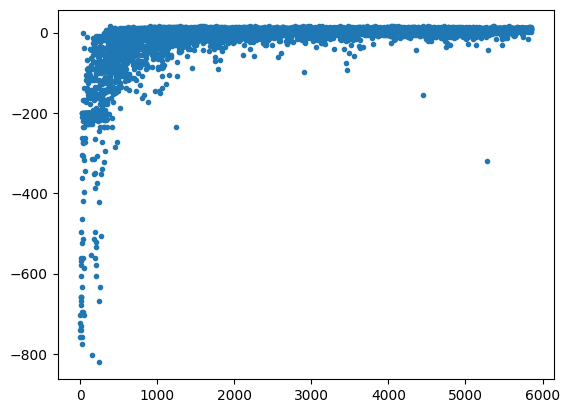

In [40]:
plt.scatter(range(len(episode_rewards)), episode_rewards, marker='.')